In [1]:
# Let's prepare the data for testing and validation in models

from constants import target_name, x_path, y_path, preprocessed_data
from libs.simple_processing import separate_target, normalize
import pandas as pd

data = pd.read_csv(preprocessed_data, engine='python')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   month_number   1609124 non-null  int64
 1   shop_id        1609124 non-null  int64
 2   item_id        1609124 non-null  int64
 3   monthly_sales  1609124 non-null  int64
dtypes: int64(4)
memory usage: 49.1 MB


   month_number  monthly_sales
0            20              1
1            22              1
2            23              2
3            24              2
4            28              1
5            29              1
6            30              1
7            31              3
8            32              1


KeyError: 1

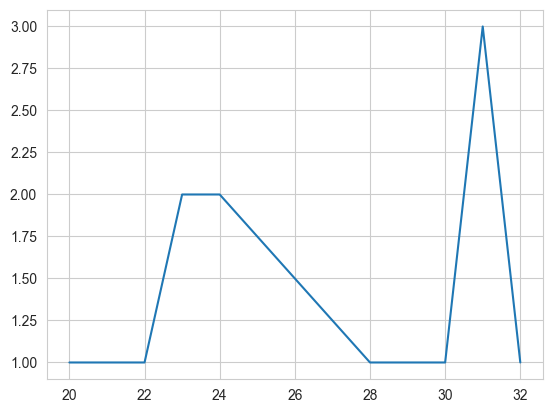

In [2]:

# Looks like the shop id is much better option - it is used almost 100K times
# Let's validate by drawing a global sales history for that shop

from pandas import DataFrame
import matplotlib.pyplot as plt

shop_id = 5
item_id = 5037

# selected = monthly_sales.query('item_id==5822')
by_shop = data.query(f'shop_id=={shop_id} and item_id=={item_id}')
sales_shop = by_shop.groupby(['month_number'], as_index=False)['monthly_sales'].sum()

print(sales_shop)

fig, ax = plt.subplots()
ax.plot(sales_shop.month_number, sales_shop.monthly_sales)
plt.plot(sales_shop[1])

In [3]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    # print(dataset)
    dataX, dataY = [], []
    for curri in range(len(dataset)-look_back-1):
        nexti = curri + look_back
        # print(nexti)
        dataX.append(dataset[curri: nexti])
        dataY.append(dataset[nexti: nexti + 1])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
X, y = create_dataset(sales_shop.monthly_sales, look_back)

print('X: ', X, 'y: ', y)


X:  [[1]
 [1]
 [2]
 [2]
 [1]
 [1]
 [1]] y:  [[1]
 [2]
 [2]
 [1]
 [1]
 [1]
 [3]]


In [4]:

# reshape input to be: [samples, time steps, features]
# .reshape(X, (rows, cols
print(X.shape)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
print(X.shape)
print(X)

(7, 1)
(7, 1, 1)
[[[1]]

 [[1]]

 [[2]]

 [[2]]

 [[1]]

 [[1]]

 [[1]]]


In [5]:
print(y.shape)
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))
print(y.shape)

(7, 1)
(7, 1, 1)


2023-01-09 14:25:30.271062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 14:25:30.271302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Epoch 1/1500


2023-01-09 14:25:31.270111: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-09 14:25:31.929092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 14:25:32.187923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 14:25:33.292625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 13ms/step - loss: 1.5683 - mean_absolute_error: 1.5683
Epoch 2/1500
7/7 [==============================] - 0s 8ms/step - loss: 1.5557 - mean_absolute_error: 1.5557
Epoch 3/1500
7/7 [==============================] - 0s 8ms/step - loss: 1.5432 - mean_absolute_error: 1.5432
Epoch 4/1500
7/7 [==============================] - 0s 7ms/step - loss: 1.5308 - mean_absolute_error: 1.5308
Epoch 5/1500
7/7 [==============================] - 0s 7ms/step - loss: 1.5183 - mean_absolute_error: 1.5183
Epoch 6/1500
7/7 [==============================] - 0s 7ms/step - loss: 1.5055 - mean_absolute_error: 1.5055
Epoch 7/1500
7/7 [==============================] - 0s 8ms/step - loss: 1.4925 - mean_absolute_error: 1.4925
Epoch 8/1500
7/7 [==============================] - 0s 8ms/step - loss: 1.4794 - mean_absolute_error: 1.4794
Epoch 9/1500
7/7 [==============================] - 0s 7ms/step - loss: 1.4658 - mean_absolute_error: 1.4658
Epoch 10/1500
7/7 [============

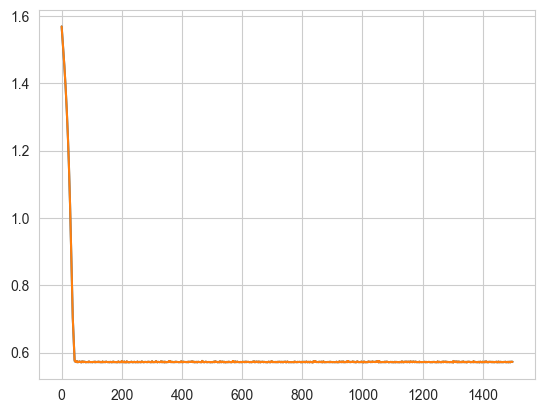

In [6]:
import tensorflow as tf
from libs.simple_plotter import plot_history

X_train = X.copy()
y_train = y.copy()

# features_count = X_train.shape[0]

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005,    # minimium amount of change to count as an improvement
    patience=7,         # how many epochs to wait before stopping
    restore_best_weights=True
)

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(4, input_shape=(1, look_back)))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam()
              , loss=tf.keras.losses.MeanAbsoluteError()
              , metrics=tf.metrics.MeanAbsoluteError())

history = model.fit(X_train, y_train
                    , epochs=1500
                    , callbacks=[early_stopping]
                    , batch_size = 1
                    , use_multiprocessing=True)

# print(history.history)
plot_history(history)


In [9]:
last_month = [[1]]
pred = model.predict(last_month) # sales from last month
print(pred)


1/1 [==============================] - 0s 28ms/step
[[1.0039649]]


2023-01-09 14:45:31.424963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 14:45:31.794970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


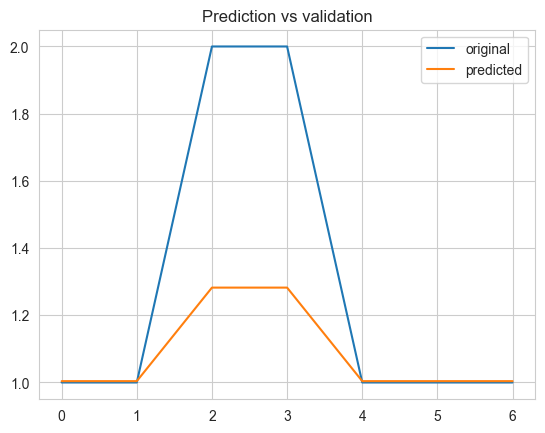

<Figure size 4000x1500 with 0 Axes>

In [10]:
y_pred = model.predict(X_train)

scale = range(len(y_pred))
plt.plot(scale, sales_shop.monthly_sales[:len(y_pred)], label="original")
plt.plot(scale, y_pred, label="predicted")
plt.title("Prediction vs validation")
plt.legend()
fig = plt.figure(figsize=(40, 15))
